<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb) | [Contents](Index.ipynb) | [Fancy Indexing](02.07-Fancy-Indexing.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.06-Boolean-Arrays-and-Masks.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Comparisons, Masks, and Boolean Logic

This section covers the use of Boolean masks to examine and manipulate values within NumPy arrays.
Masking comes up when you want to extract, modify, count, or otherwise manipulate values in an array based on some criterion: for example, you might wish to count all values greater than a certain value, or perhaps remove all outliers that are above some threshold.
In NumPy, Boolean masking is often the most efficient way to accomplish these types of tasks.

## Example: Counting Rainy Days

Imagine you have a series of data that represents the amount of precipitation each day for a year in a given city.
For example, here we'll load the daily rainfall statistics for the city of Seattle in 2014, using Pandas (which is covered in more detail in [Chapter 3](03.00-Introduction-to-Pandas.ipynb)):

In [1]:
import numpy as np
import pandas as pd

# use pandas to extract rainfall inches as a NumPy array
rainfall = pd.read_csv('data/Seattle2014.csv')['PRCP'].values
inches = rainfall / 254.0  # 1/10mm -> inches
inches.shape

(365,)

The array contains 365 values, giving daily rainfall in inches from January 1 to December 31, 2014.

As a first quick visualization, let's look at the histogram of rainy days, which was generated using Matplotlib (we will explore this tool more fully in [Chapter 4](04.00-Introduction-To-Matplotlib.ipynb)):

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # set plot styles

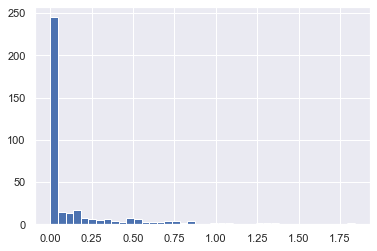

In [3]:
plt.hist(inches, 40);

This histogram gives us a general idea of what the data looks like: despite its reputation, the vast majority of days in Seattle saw near zero measured rainfall in 2014.
But this doesn't do a good job of conveying some information we'd like to see: for example, how many rainy days were there in the year? What is the average precipitation on those rainy days? How many days were there with more than half an inch of rain?

### Digging into the data

One approach to this would be to answer these questions by hand: loop through the data, incrementing a counter each time we see values in some desired range.
For reasons discussed throughout this chapter, such an approach is very inefficient, both from the standpoint of time writing code and time computing the result.
We saw in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) that NumPy's ufuncs can be used in place of loops to do fast element-wise arithmetic operations on arrays; in the same way, we can use other ufuncs to do element-wise *comparisons* over arrays, and we can then manipulate the results to answer the questions we have.
We'll leave the data aside for right now, and discuss some general tools in NumPy to use *masking* to quickly answer these types of questions.

## Comparison Operators as ufuncs

In [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) we introduced ufuncs, and focused in particular on arithmetic operators. We saw that using ``+``, ``-``, ``*``, ``/``, and others on arrays leads to element-wise operations.
NumPy also implements comparison operators such as ``<`` (less than) and ``>`` (greater than) as element-wise ufuncs.
The result of these comparison operators is always an array with a Boolean data type.
All six of the standard comparison operations are available:

In [4]:
x = np.array([1, 2, 3, 4, 5])

In [5]:
x < 3  # less than

array([ True,  True, False, False, False])

In [6]:
x > 3  # greater than

array([False, False, False,  True,  True])

In [7]:
x <= 3  # less than or equal

array([ True,  True,  True, False, False])

In [8]:
x >= 3  # greater than or equal

array([False, False,  True,  True,  True])

In [9]:
x != 3  # not equal

array([ True,  True, False,  True,  True])

In [10]:
x == 3  # equal

array([False, False,  True, False, False])

It is also possible to do an element-wise comparison of two arrays, and to include compound expressions:

In [11]:
(2 * x) == (x ** 2)

array([False,  True, False, False, False])

As in the case of arithmetic operators, the comparison operators are implemented as ufuncs in NumPy; for example, when you write ``x < 3``, internally NumPy uses ``np.less(x, 3)``.
    A summary of the comparison operators and their equivalent ufunc is shown here:

| Operator	    | Equivalent ufunc    || Operator	   | Equivalent ufunc    |
|---------------|---------------------||---------------|---------------------|
|``==``         |``np.equal``         ||``!=``         |``np.not_equal``     |
|``<``          |``np.less``          ||``<=``         |``np.less_equal``    |
|``>``          |``np.greater``       ||``>=``         |``np.greater_equal`` |

Just as in the case of arithmetic ufuncs, these will work on arrays of any size and shape.
Here is a two-dimensional example:

In [14]:
rng = np.random.RandomState(0)
x = rng.randint(10, size=(3, 4))
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

In [15]:
x < 6

array([[ True,  True,  True,  True],
       [False, False,  True,  True],
       [ True,  True, False, False]])

In each case, the result is a Boolean array, and NumPy provides a number of straightforward patterns for working with these Boolean results.

## Working with Boolean Arrays

Given a Boolean array, there are a host of useful operations you can do.
We'll work with ``x``, the two-dimensional array we created earlier.

In [16]:
print(x)

[[5 0 3 3]
 [7 9 3 5]
 [2 4 7 6]]


### Counting entries

To count the number of ``True`` entries in a Boolean array, ``np.count_nonzero`` is useful:

In [17]:
# how many values less than 6?
np.count_nonzero(x < 6)

8

We see that there are eight array entries that are less than 6.
Another way to get at this information is to use ``np.sum``; in this case, ``False`` is interpreted as ``0``, and ``True`` is interpreted as ``1``:

In [18]:
np.sum(x < 6)

8

The benefit of ``sum()`` is that like with other NumPy aggregation functions, this summation can be done along rows or columns as well:

In [17]:
# how many values less than 6 in each row?
np.sum(x < 6, axis=1)

array([4, 2, 2])

This counts the number of values less than 6 in each row of the matrix.

If we're interested in quickly checking whether any or all the values are true, we can use (you guessed it) ``np.any`` or ``np.all``:

In [18]:
# are there any values greater than 8?
np.any(x > 8)

True

In [19]:
# are there any values less than zero?
np.any(x < 0)

False

In [20]:
# are all values less than 10?
np.all(x < 10)

True

In [21]:
# are all values equal to 6?
np.all(x == 6)

False

``np.all`` and ``np.any`` can be used along particular axes as well. For example:

In [22]:
# are all values in each row less than 8?
np.all(x < 8, axis=1)

array([ True, False,  True], dtype=bool)

Here all the elements in the first and third rows are less than 8, while this is not the case for the second row.

Finally, a quick warning: as mentioned in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb), Python has built-in ``sum()``, ``any()``, and ``all()`` functions. These have a different syntax than the NumPy versions, and in particular will fail or produce unintended results when used on multidimensional arrays. Be sure that you are using ``np.sum()``, ``np.any()``, and ``np.all()`` for these examples!

### Boolean operators

We've already seen how we might count, say, all days with rain less than four inches, or all days with rain greater than two inches.
But what if we want to know about all days with rain less than four inches and greater than one inch?
This is accomplished through Python's *bitwise logic operators*, ``&``, ``|``, ``^``, and ``~``.
Like with the standard arithmetic operators, NumPy overloads these as ufuncs which work element-wise on (usually Boolean) arrays.

For example, we can address this sort of compound question as follows:

In [23]:
np.sum((inches > 0.5) & (inches < 1))

29

So we see that there are 29 days with rainfall between 0.5 and 1.0 inches.

Note that the parentheses here are important–because of operator precedence rules, with parentheses removed this expression would be evaluated as follows, which results in an error:

``` python
inches > (0.5 & inches) < 1
```

Using the equivalence of *A AND B* and *NOT (NOT A OR NOT B)* (which you may remember if you've taken an introductory logic course), we can compute the same result in a different manner:

In [24]:
np.sum(~( (inches <= 0.5) | (inches >= 1) ))

29

Combining comparison operators and Boolean operators on arrays can lead to a wide range of efficient logical operations.

The following table summarizes the bitwise Boolean operators and their equivalent ufuncs:

| Operator	    | Equivalent ufunc    || Operator	    | Equivalent ufunc    |
|---------------|---------------------||---------------|---------------------|
|``&``          |``np.bitwise_and``   ||&#124;         |``np.bitwise_or``    |
|``^``          |``np.bitwise_xor``   ||``~``          |``np.bitwise_not``   |

Using these tools, we might start to answer the types of questions we have about our weather data.
Here are some examples of results we can compute when combining masking with aggregations:

In [25]:
print("Number days without rain:      ", np.sum(inches == 0))
print("Number days with rain:         ", np.sum(inches != 0))
print("Days with more than 0.5 inches:", np.sum(inches > 0.5))
print("Rainy days with < 0.2 inches  :", np.sum((inches > 0) &
                                                (inches < 0.2)))

Number days without rain:       215
Number days with rain:          150
Days with more than 0.5 inches: 37
Rainy days with < 0.2 inches  : 75


## Boolean Arrays as Masks

In the preceding section we looked at aggregates computed directly on Boolean arrays.
A more powerful pattern is to use Boolean arrays as masks, to select particular subsets of the data themselves.
Returning to our ``x`` array from before, suppose we want an array of all values in the array that are less than, say, 5:

In [26]:
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

We can obtain a Boolean array for this condition easily, as we've already seen:

In [27]:
x < 5

array([[False,  True,  True,  True],
       [False, False,  True, False],
       [ True,  True, False, False]], dtype=bool)

Now to *select* these values from the array, we can simply index on this Boolean array; this is known as a *masking* operation:

In [28]:
x[x < 5]

array([0, 3, 3, 3, 2, 4])

What is returned is a one-dimensional array filled with all the values that meet this condition; in other words, all the values in positions at which the mask array is ``True``.

We are then free to operate on these values as we wish.
For example, we can compute some relevant statistics on our Seattle rain data:

In [29]:
# construct a mask of all rainy days
rainy = (inches > 0)

# construct a mask of all summer days (June 21st is the 172nd day)
days = np.arange(365)
summer = (days > 172) & (days < 262)

print("Median precip on rainy days in 2014 (inches):   ",
      np.median(inches[rainy]))
print("Median precip on summer days in 2014 (inches):  ",
      np.median(inches[summer]))
print("Maximum precip on summer days in 2014 (inches): ",
      np.max(inches[summer]))
print("Median precip on non-summer rainy days (inches):",
      np.median(inches[rainy & ~summer]))

Median precip on rainy days in 2014 (inches):    0.194881889764
Median precip on summer days in 2014 (inches):   0.0
Maximum precip on summer days in 2014 (inches):  0.850393700787
Median precip on non-summer rainy days (inches): 0.200787401575


By combining Boolean operations, masking operations, and aggregates, we can very quickly answer these sorts of questions for our dataset.

## Aside: Using the Keywords and/or Versus the Operators &/|

One common point of confusion is the difference between the keywords ``and`` and ``or`` on one hand, and the operators ``&`` and ``|`` on the other hand.
When would you use one versus the other?

The difference is this: ``and`` and ``or`` gauge the truth or falsehood of *entire object*, while ``&`` and ``|`` refer to *bits within each object*.

When you use ``and`` or ``or``, it's equivalent to asking Python to treat the object as a single Boolean entity.
In Python, all nonzero integers will evaluate as True. Thus:

In [30]:
bool(42), bool(0)

(True, False)

In [31]:
bool(42 and 0)

False

In [32]:
bool(42 or 0)

True

When you use ``&`` and ``|`` on integers, the expression operates on the bits of the element, applying the *and* or the *or* to the individual bits making up the number:

In [33]:
bin(42)

'0b101010'

In [34]:
bin(59)

'0b111011'

In [35]:
bin(42 & 59)

'0b101010'

In [36]:
bin(42 | 59)

'0b111011'

Notice that the corresponding bits of the binary representation are compared in order to yield the result.

When you have an array of Boolean values in NumPy, this can be thought of as a string of bits where ``1 = True`` and ``0 = False``, and the result of ``&`` and ``|`` operates similarly to above:

In [37]:
A = np.array([1, 0, 1, 0, 1, 0], dtype=bool)
B = np.array([1, 1, 1, 0, 1, 1], dtype=bool)
A | B

array([ True,  True,  True, False,  True,  True], dtype=bool)

Using ``or`` on these arrays will try to evaluate the truth or falsehood of the entire array object, which is not a well-defined value:

In [38]:
A or B

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Similarly, when doing a Boolean expression on a given array, you should use ``|`` or ``&`` rather than ``or`` or ``and``:

In [39]:
x = np.arange(10)
(x > 4) & (x < 8)

array([False, False, False, False, False,  True,  True,  True, False, False], dtype=bool)

Trying to evaluate the truth or falsehood of the entire array will give the same ``ValueError`` we saw previously:

In [40]:
(x > 4) and (x < 8)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

So remember this: ``and`` and ``or`` perform a single Boolean evaluation on an entire object, while ``&`` and ``|`` perform multiple Boolean evaluations on the content (the individual bits or bytes) of an object.
For Boolean NumPy arrays, the latter is nearly always the desired operation.

<!--NAVIGATION-->
< [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb) | [Contents](Index.ipynb) | [Fancy Indexing](02.07-Fancy-Indexing.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.06-Boolean-Arrays-and-Masks.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
